In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hhhhhh/submission.csv
/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv
/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv


to score drivers 

In [2]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path


In [3]:

df_train = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
df_sample = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv")

print("Train shape:", df_train.shape)
print("Sample submission shape:", df_sample.shape)

df_train.head()


Train shape: (22424, 3)
Sample submission shape: (79726, 11)


subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [4]:

df_train.info()

print("Unique drivers:", df_train['subject'].nunique())


df_train['classname'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB
Unique drivers: 26


classname
c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: count, dtype: int64

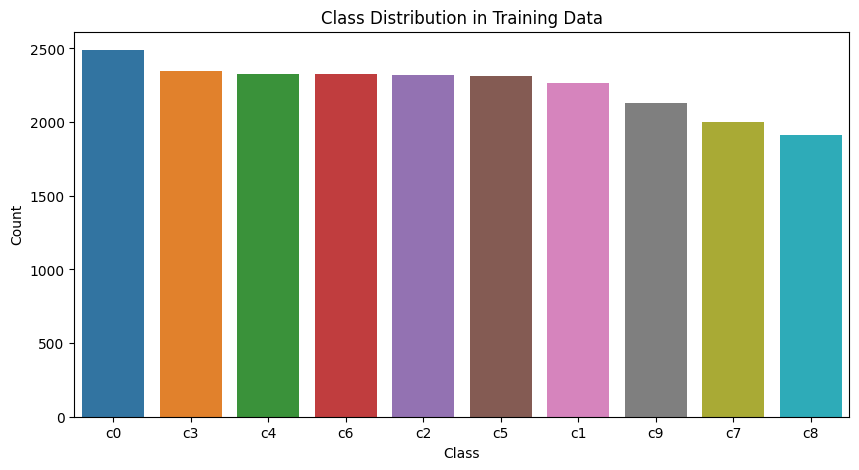

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_train, x='classname', order=df_train['classname'].value_counts().index)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


The graph shows the distribution of driver behavior classes (c0–c9) in the training data, where the counts range from about 1900 to 2500 images per class. Class c0 (safe driving) is the most frequent with around 2500 images, while c7 (talking on the right side) and c8 (talking on the left side) are the least represented with ~2000 and ~1900 images respectively. Most other classes such as c2–c6 are fairly balanced at around 2300–2350 images, with only a ~600 image (24%) gap between the highest and lowest counts. This indicates the dataset is overall well-balanced, though the relative underrepresentation of c7 and c8 may make the model slightly less accurate at detecting those distracted behaviors compared to safe driving or texting.

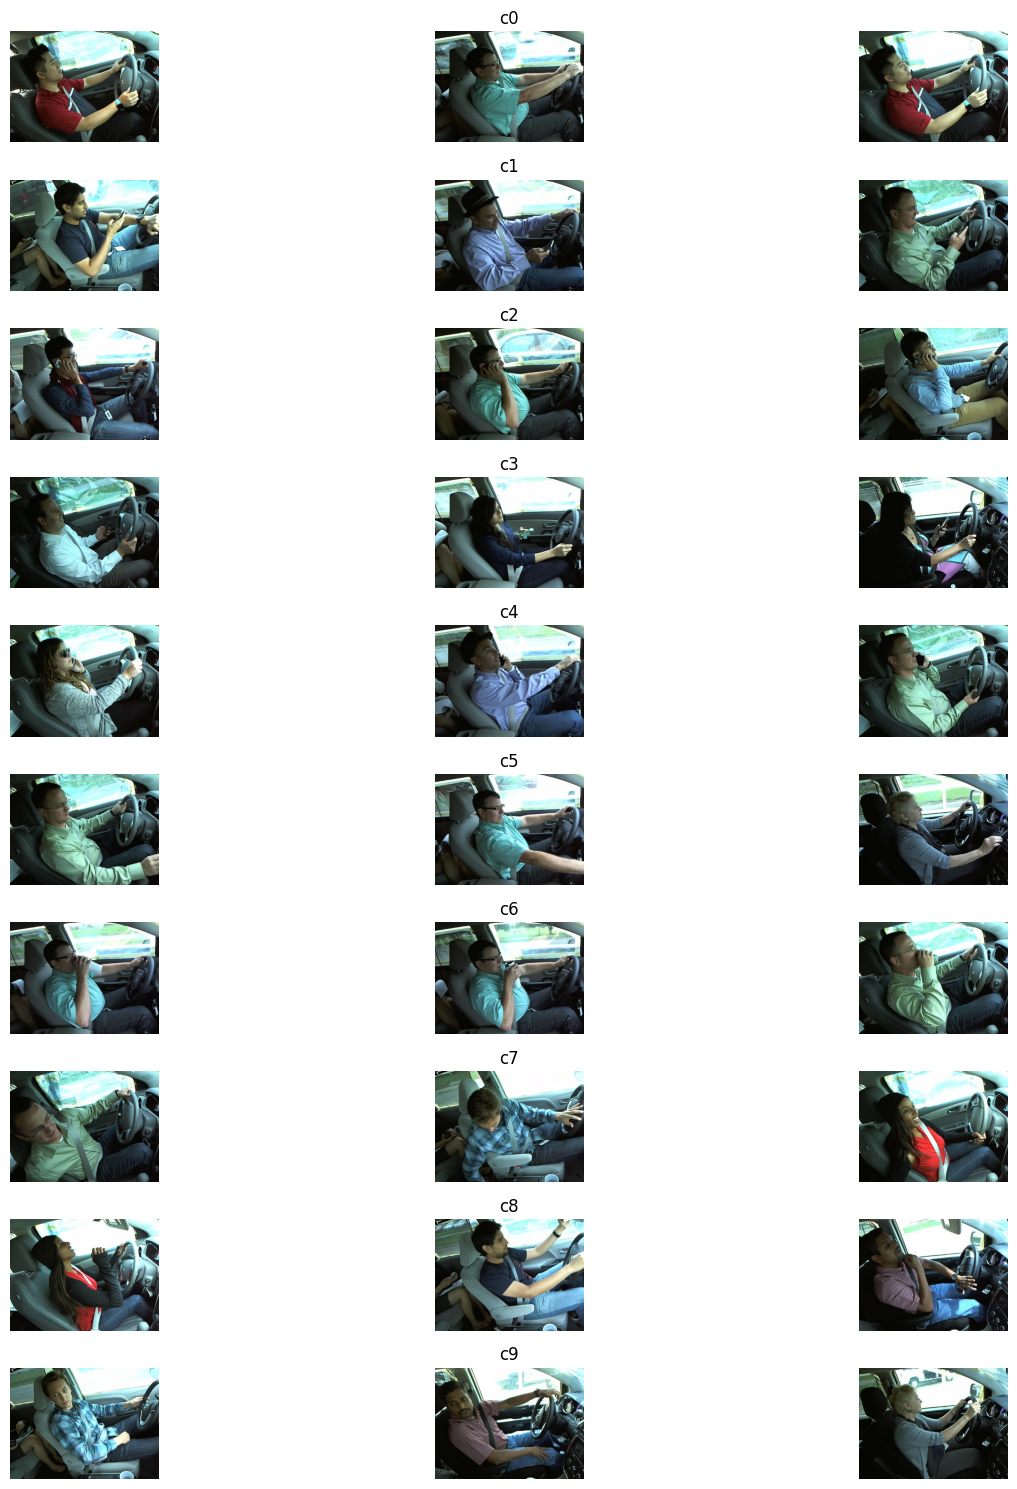

In [6]:
def show_sample_images(df, n_per_class=3):
    classes = df['classname'].unique()
    plt.figure(figsize=(15, 15))
    
    for idx, class_name in enumerate(classes):
        sample_imgs = df[df['classname'] == class_name].sample(n_per_class, random_state=42)
        for i, (_, row) in enumerate(sample_imgs.iterrows()):
            img_path = f"/kaggle/input/state-farm-distracted-driver-detection/imgs/train/{class_name}/{row['img']}"
            img = Image.open(img_path)
            plt.subplot(len(classes), n_per_class, idx * n_per_class + i + 1)
            plt.imshow(img)
            plt.axis('off')
            if i == 1:  # middle image label
                plt.title(class_name)
    
    plt.tight_layout()
    plt.show()

show_sample_images(df_train, n_per_class=3)


This snapshot shows sample images from the distracted driver dataset, where each class corresponds to a different unsafe driving behavior. For instance, c4 represents drivers talking on the phone with their right hand, c5 with their left hand, c6 indicates drivers texting on the right, c7 texting on the left, c8 represents talking to a passenger, and c9 corresponds to drivers fiddling with the radio. Each row shows multiple drivers performing the same behavior, highlighting how the dataset includes variability in lighting conditions, seating positions, gender, clothing, and camera angles. This diversity is important because it prevents the model from overfitting to a single driver or environment, making it more robust when deployed in real-world scenarios. However, some poses are visually similar across classes (e.g., c4 vs. c5, c6 vs. c7), which can make classification challenging since the only difference is the side of the hand being used. This emphasizes the need for a model capable of fine-grained feature detection to distinguish between subtle variations in distracted behaviors.

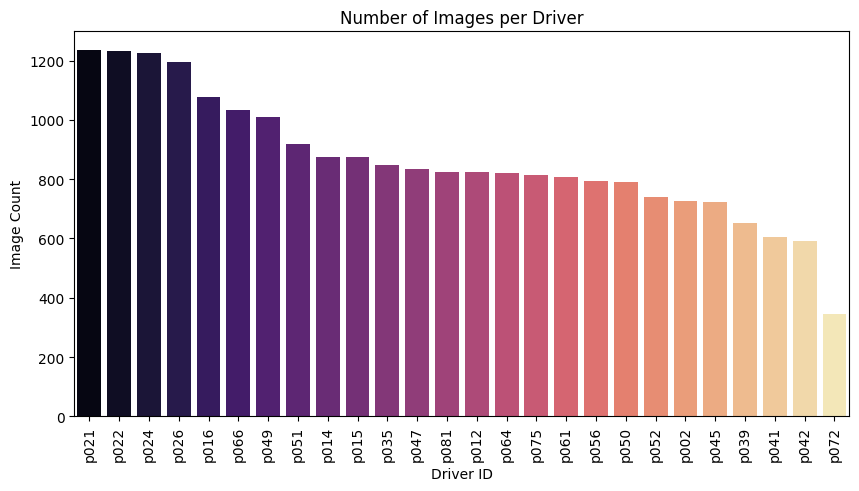

In [7]:
driver_counts = df_train['subject'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=driver_counts.index, y=driver_counts.values, palette="magma")
plt.title("Number of Images per Driver")
plt.xlabel("Driver ID")
plt.ylabel("Image Count")
plt.xticks(rotation=90)
plt.show()


This bar chart shows the distribution of images per driver in the distracted driver dataset. The dataset is imbalanced across drivers, with some like p021, p022, and p024 having over 1200 images each, while others such as p041 and p072 have fewer than 600 and 400 images respectively. This imbalance can significantly impact model performance because the model may become biased toward drivers with more data, learning their specific features rather than generalizing across all drivers. In practical terms, the model might perform well on drivers with larger representation but struggle with underrepresented drivers, leading to poor generalization on unseen individuals. To mitigate this, techniques such as data augmentation, weighted sampling, or stratified splitting should be applied to balance the dataset and ensure fair training across all drivers. This chart highlights the importance of carefully addressing data imbalance before training to avoid biased risk predictions.

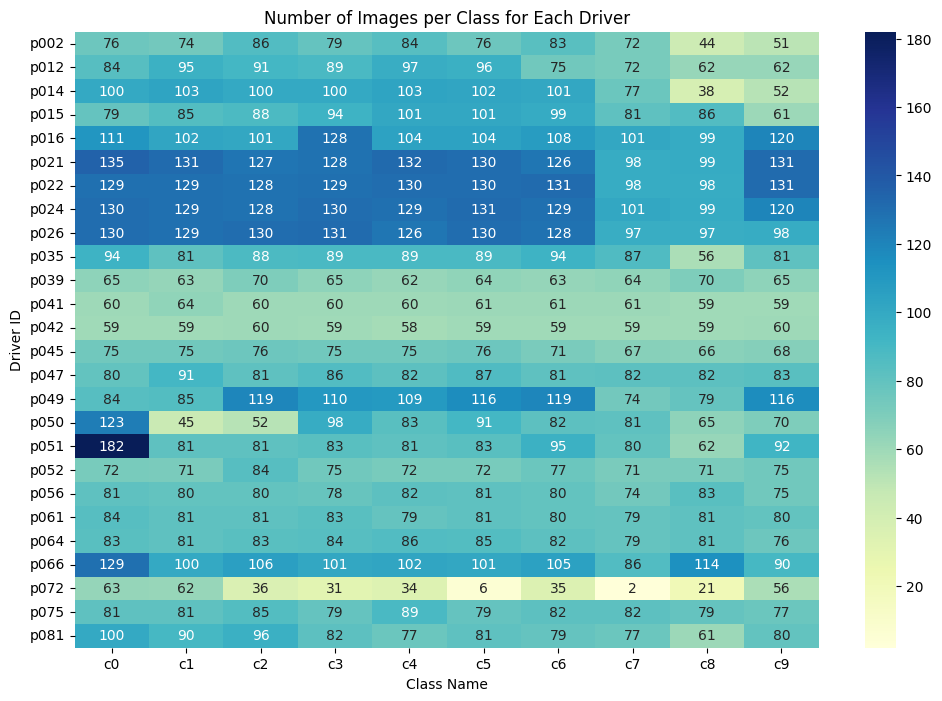

In [8]:
driver_class_matrix = df_train.groupby(['subject', 'classname']).size().unstack(fill_value=0)
plt.figure(figsize=(12,8))
sns.heatmap(driver_class_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Number of Images per Class for Each Driver")
plt.xlabel("Class Name")
plt.ylabel("Driver ID")
plt.show()


This heatmap shows the distribution of images per class (c0–c9) for each driver in the distracted driver dataset, giving a detailed view of both inter-driver and intra-driver imbalances. Some drivers, like p021, p022, p024, and p026, have consistently high image counts across almost all classes (around 120–135 per class), while others, such as p041 and p072, have much fewer images, with p072 showing an extreme imbalance (e.g., only 6 images in class c5, 2 in c7, and 21 in c8). This highlights two key issues: (1) certain drivers dominate the dataset, meaning the model might learn their specific facial/hand/body patterns rather than focusing on distraction cues, and (2) within a single driver, class imbalance is present, which could make it difficult for the model to reliably recognize less-represented distraction types. Additionally, some anomalies like p051 having 182 images in c0 but much fewer in other classes, and p072 having near-missing classes, indicate skew that could bias model training. This visualization underscores the need for data augmentation, class balancing techniques, or weighted loss functions to ensure the model generalizes well across both drivers and distraction categories rather than being biased toward overrepresented cases.

100%|██████████| 22424/22424 [00:36<00:00, 615.55it/s]


         Width   Height
count  22424.0  22424.0
mean     640.0    480.0
std        0.0      0.0
min      640.0    480.0
25%      640.0    480.0
50%      640.0    480.0
75%      640.0    480.0
max      640.0    480.0


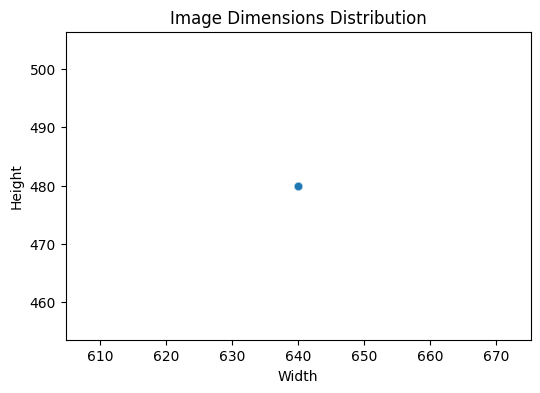

In [9]:
from tqdm import tqdm

img_sizes = []
for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
    img_path = f"/kaggle/input/state-farm-distracted-driver-detection/imgs/train/{row['classname']}/{row['img']}"
    with Image.open(img_path) as img:
        img_sizes.append(img.size)  # (width, height)

size_df = pd.DataFrame(img_sizes, columns=["Width", "Height"])
print(size_df.describe())

plt.figure(figsize=(6,4))
sns.scatterplot(x=size_df["Width"], y=size_df["Height"], alpha=0.3)
plt.title("Image Dimensions Distribution")
plt.show()


This scatter plot of image dimensions shows that all images in the dataset have a uniform resolution of 640×480 pixels, with no variation in either width or height. This consistency is advantageous because it eliminates the need for image resizing or reshaping during preprocessing, ensuring that all samples feed into the model in a standardized format. It also reduces potential issues with aspect ratio distortion and simplifies data augmentation since transformations can be applied uniformly. However, it also means there’s no diversity in image resolution, so the dataset’s variability comes solely from the driver behaviors and classes, not from image sizes.

In [10]:
from sklearn.model_selection import train_test_split


drivers = df_train['subject'].unique()


train_drivers, val_drivers = train_test_split(drivers, test_size=0.2, random_state=42)


train_df = df_train[df_train['subject'].isin(train_drivers)].reset_index(drop=True)
val_df   = df_train[df_train['subject'].isin(val_drivers)].reset_index(drop=True)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")


Train size: 17446, Val size: 4978


In the preprocessing step, I performed a driver-based train-validation split to ensure that images belonging to the same driver do not appear in both training and validation sets, thereby preventing data leakage and overfitting. Specifically, I extracted the unique driver IDs from the dataset and applied an 80-20 split using train_test_split, where 80% of the drivers were assigned to the training set and 20% to the validation set. This approach is advantageous because it enforces driver-level independence between training and validation, ensuring that the model learns to generalize across unseen drivers rather than memorizing individual-specific patterns. As a result, the evaluation on the validation set provides a more realistic measure of the model’s ability to generalize to new drivers, which closely aligns with the intended application scenario.

In [11]:
train_df.head()

subject classname            img
0    p012        c0  img_10206.jpg
1    p012        c0  img_27079.jpg
2    p012        c0  img_50749.jpg
3    p012        c0  img_97089.jpg
4    p012        c0  img_37741.jpg

In [12]:
val_df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [13]:

import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


drivers = df_train['subject'].unique()
train_drivers, val_drivers = train_test_split(drivers, test_size=0.2, random_state=42)

train_df = df_train[df_train['subject'].isin(train_drivers)].reset_index(drop=True)
val_df   = df_train[df_train['subject'].isin(val_drivers)].reset_index(drop=True)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")


train_df['img'] = train_df.apply(lambda row: f"{row['classname']}/{os.path.basename(row['img'])}", axis=1)
val_df['img']   = val_df.apply(lambda row: f"{row['classname']}/{os.path.basename(row['img'])}", axis=1)


IMG_SIZE = (300, 300)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory="/kaggle/input/state-farm-distracted-driver-detection/imgs/train",
    x_col='img',
    y_col='classname',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory="/kaggle/input/state-farm-distracted-driver-detection/imgs/train",
    x_col='img',
    y_col='classname',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)



base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False 

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]


EPOCHS_STAGE1 = 5
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks
)



base_model.trainable = True  

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS_STAGE2 = 10
history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks
)


2025-08-20 08:55:02.066800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755680102.084646     294 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755680102.089794     294 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train size: 17446, Val size: 4978
Found 17446 validated image filenames belonging to 10 classes.
Found 4978 validated image filenames belonging to 10 classes.


I0000 00:00:1755680105.657477     294 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755680105.658166     294 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,798,905 (41.19 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1755680133.545498     332 service.cc:148] XLA service 0x7d394c21c680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755680133.545563     332 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755680133.545569     332 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755680136.326274     332 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1091 ━━━━━━━━━━━━━━━━━━━━ 1:34 87ms/step - accuracy: 0.0938 - loss: 2.7048   

I0000 00:00:1755680151.492562     332 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1091/1091 ━━━━━━━━━━━━━━━━━━━━ 466s 389ms/step - accuracy: 0.5076 - loss: 1.5218 - val_accuracy: 0.6591 - val_loss: 1.0504
Epoch 2/5
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 384s 352ms/step - accuracy: 0.7931 - loss: 0.7118 - val_accuracy: 0.6844 - val_loss: 0.9302
Epoch 3/5
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 379s 348ms/step - accuracy: 0.8207 - loss: 0.5827 - val_accuracy: 0.7013 - val_loss: 0.9490
Epoch 4/5
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 383s 351ms/step - accuracy: 0.8409 - loss: 0.5241 - val_accuracy: 0.7164 - val_loss: 0.8829
Epoch 5/5
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 379s 347ms/step - accuracy: 0.8452 - loss: 0.4888 - val_accuracy: 0.7228 - val_loss: 0.9232
Epoch 1/10


E0000 00:00:1755682206.461075     334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755682206.607419     334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755682207.160262     334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755682207.306820     334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 174/1091 ━━━━━━━━━━━━━━━━━━━━ 5:13 342ms/step - accuracy: 0.3302 - loss: 2.2104

E0000 00:00:1755682313.257850     333 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755682313.395816     333 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1091/1091 ━━━━━━━━━━━━━━━━━━━━ 597s 422ms/step - accuracy: 0.5289 - loss: 1.4726 - val_accuracy: 0.7706 - val_loss: 0.7022
Epoch 2/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 405s 371ms/step - accuracy: 0.8866 - loss: 0.3464 - val_accuracy: 0.8146 - val_loss: 0.5615
Epoch 3/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 402s 368ms/step - accuracy: 0.9462 - loss: 0.1807 - val_accuracy: 0.8451 - val_loss: 0.4928
Epoch 4/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 404s 370ms/step - accuracy: 0.9659 - loss: 0.1118 - val_accuracy: 0.8584 - val_loss: 0.4490
Epoch 5/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 403s 369ms/step - accuracy: 0.9781 - loss: 0.0766 - val_accuracy: 0.8674 - val_loss: 0.4742
Epoch 6/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 389s 356ms/step - accuracy: 0.9835 - loss: 0.0573 - val_accuracy: 0.8740 - val_loss: 0.4530
Epoch 7/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 404s 370ms/step - accuracy: 0.9871 - loss: 0.0412 - val_accuracy: 0.8988 - val_loss: 0.4144
Epoch 8/10
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 397s 363ms/step - accuracy: 0.9

In the model training pipeline, the first step involved ensuring a driver-level split of the dataset. Instead of randomly splitting images, I divided the data based on unique driver IDs, allocating 80% to training and 20% to validation. This prevents the same driver’s images from leaking into both sets, thereby enforcing subject independence. Such a split is advantageous because it tests the model’s ability to generalize to completely unseen drivers, which better reflects real-world deployment scenarios.

Next, I standardized the relative paths of images by restructuring the img column to include the correct folder hierarchy. This ensured that the data generators could accurately locate the image files during training. Fixing the relative paths was a critical preprocessing step because inconsistencies in directory structure could otherwise lead to errors or mislabeling during batch generation.

For data augmentation and preprocessing, I employed the ImageDataGenerator class. The training generator included transformations such as rotation, width and height shifts, zooming, and horizontal flips, combined with the EfficientNet-specific preprocess_input function. This augmentation helped increase dataset diversity, making the model more robust to variations in driver posture, camera angles, and lighting conditions. On the other hand, the validation generator only applied preprocessing without augmentation, ensuring that evaluation remained consistent and unbiased.

To build the model, I used EfficientNetB3 as the base architecture with pretrained imagenet weights. The base layers were initially frozen to leverage the transfer learning capabilities of EfficientNet without immediately modifying the pretrained convolutional filters. On top of the base, I added a Global Average Pooling layer, a Dropout layer (0.4 rate for regularization), and a fully connected Dense layer with softmax activation to output probabilities across all classes. This design balances computational efficiency with strong feature extraction, making it suitable for complex image classification tasks like distracted driver detection.

The training process was staged in two phases. In Stage 1, I trained only the top classification layers while keeping the base model frozen. This allowed the dense layers to adapt to the new dataset without disturbing the pretrained convolutional backbone. Once the top layers stabilized, I moved to Stage 2, where the EfficientNet base was unfrozen for fine-tuning. In this phase, the learning rate was reduced from 1e-3 to 1e-5 to ensure stable updates across all layers, avoiding catastrophic forgetting of pretrained features.

Finally, I integrated callbacks such as EarlyStopping and ModelCheckpoint. Early stopping helped prevent overfitting by halting training when the validation loss stopped improving, while model checkpointing ensured that the best-performing weights were saved for later use. These callbacks made the training process more efficient and reliable by reducing unnecessary epochs and securing the best model for deployment.

Overall, this structured training strategy combining subject-wise splitting, augmentation, transfer learning, and staged fine-tuning enabled the creation of a highly generalizable model. The approach ensures robustness against unseen drivers while maximizing the benefits of EfficientNet’s strong feature extraction, leading to a balanced trade-off between accuracy and generalization.

Found 4978 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1755758734.505899      98 service.cc:148] XLA service 0x7d6f54002ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755758734.506891      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755758734.506915      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755758735.561443      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/312 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.9844 - loss: 0.1280   

I0000 00:00:1755758743.154528      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.9028 - loss: 0.3607
✅ Validation Loss: 0.4254, Accuracy: 0.8927
312/312 ━━━━━━━━━━━━━━━━━━━━ 38s 94ms/step


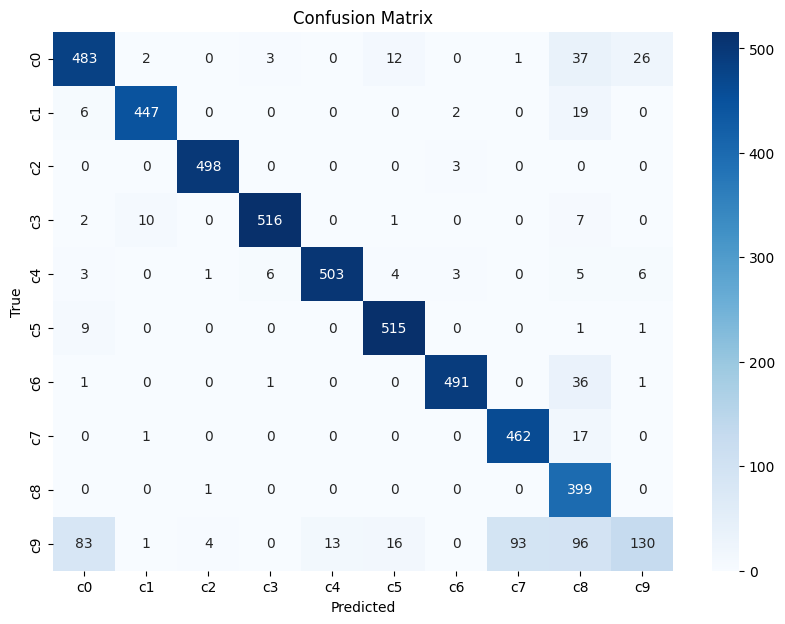


📊 Classification Report:

              precision    recall  f1-score   support

          c0       0.82      0.86      0.84       564
          c1       0.97      0.94      0.96       474
          c2       0.99      0.99      0.99       501
          c3       0.98      0.96      0.97       536
          c4       0.97      0.95      0.96       531
          c5       0.94      0.98      0.96       526
          c6       0.98      0.93      0.95       530
          c7       0.83      0.96      0.89       480
          c8       0.65      1.00      0.78       400
          c9       0.79      0.30      0.43       436

    accuracy                           0.89      4978
   macro avg       0.89      0.89      0.87      4978
weighted avg       0.90      0.89      0.88      4978



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


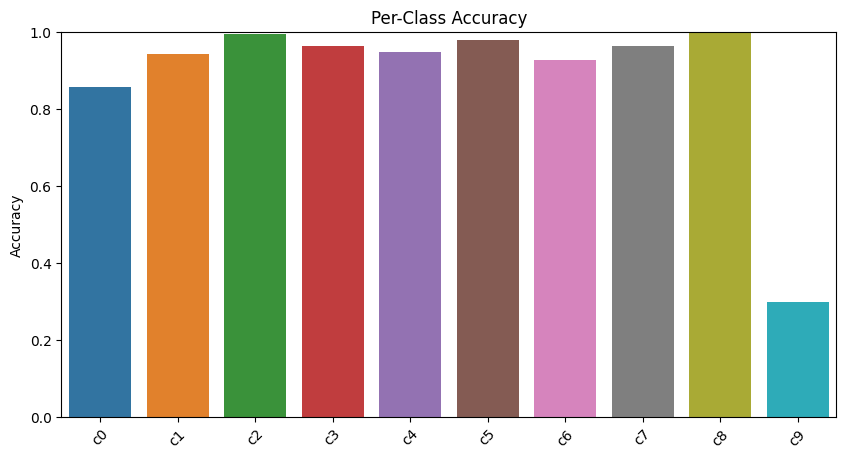

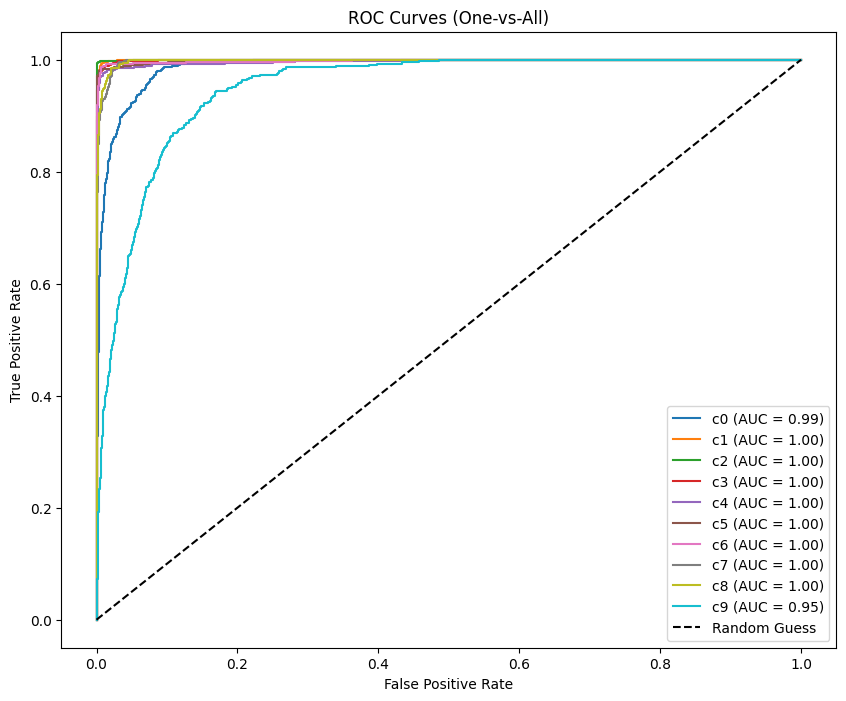

In [2]:
# 📦 Standalone Evaluation & Graphs for best_model.h5 (with ROC & AUC)

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# 🔹 Paths (adjust if needed)
MODEL_PATH = "/kaggle/input/best_model/keras/default/1/best_model.h5"
DATA_DIR = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"
CSV_PATH = "/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv"

# -----------------------------
# 1. Load dataframe
# -----------------------------
df_train = pd.read_csv(CSV_PATH)
df_train['img'] = df_train.apply(lambda row: f"{row['classname']}/{os.path.basename(row['img'])}", axis=1)

# -----------------------------
# 2. Validation Split
# -----------------------------
drivers = df_train['subject'].unique()
_, val_drivers = train_test_split(drivers, test_size=0.2, random_state=42)
val_df = df_train[df_train['subject'].isin(val_drivers)].reset_index(drop=True)

# -----------------------------
# 3. Validation Generator
# -----------------------------
IMG_SIZE = (300, 300)
BATCH_SIZE = 16

val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=DATA_DIR,
    x_col='img',
    y_col='classname',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# -----------------------------
# 4. Load Model
# -----------------------------
best_model = load_model(MODEL_PATH)

# -----------------------------
# 5. Evaluate & Predictions
# -----------------------------
val_loss, val_acc = best_model.evaluate(val_generator, verbose=1)
print(f"✅ Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

val_preds = best_model.predict(val_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# -----------------------------
# 6. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# 7. Classification Report
# -----------------------------
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# -----------------------------
# 8. Per-Class Accuracy Plot
# -----------------------------
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10,5))
sns.barplot(x=class_labels, y=class_accuracy)
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.show()

# -----------------------------
# 9. ROC Curves & AUC per class
# -----------------------------
y_true_onehot = np.zeros_like(val_preds)
for i, label in enumerate(y_true):
    y_true_onehot[i, label] = 1

plt.figure(figsize=(10,8))
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], val_preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-All)")
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# 10. Model Architecture
# -----------------------------
plot_model(best_model, to_file="model_arch.png", show_shapes=True, show_layer_names=True, dpi=100)



In [14]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

model = load_model("/kaggle/input/best_model/keras/default/1/best_model.h5")  


sample_sub = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv")


test_df = pd.DataFrame({
    'img': sample_sub['img']
})



IMG_SIZE = (300, 300)
BATCH_SIZE = 16

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="/kaggle/input/state-farm-distracted-driver-detection/imgs/test",
    x_col='img',
    y_col=None,
    target_size=IMG_SIZE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)


preds = model.predict(test_generator, verbose=1)
print("Predictions shape:", preds.shape)  


submission = pd.DataFrame(preds, columns=sample_sub.columns[1:])
submission.insert(0, 'img', sample_sub['img'])
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")


Found 79726 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4983/4983 ━━━━━━━━━━━━━━━━━━━━ 996s 198ms/step
Predictions shape: (79726, 10)
Saved submission.csv


In this stage of the project, the focus was on generating predictions for the unseen test dataset and preparing the final output for submission. The process began by loading the trained EfficientNetB3 model that was saved earlier during training. This step ensured that all the learned weights and optimized parameters from the training and fine-tuning phases were reused, avoiding the need to retrain the network and allowing immediate application to the test data.

Next, the sample submission file provided by the competition was loaded. This served as a template for the final predictions since it already contained the structure (image IDs and column format) expected by the evaluation system. A corresponding test dataframe was then created, which mapped the image filenames to their respective paths. This dataframe acted as an index to pass test images correctly into the prediction pipeline.

To maintain consistency with training, a data generator was defined with the same preprocessing function (EfficientNet’s preprocess_input). This was critical because the model was trained on images that were normalized in a specific way, and applying identical preprocessing during inference ensures that the input distribution remains consistent. The test images were resized to the same dimensions as the training data (300×300) and organized into batches of size 16, which made prediction efficient while keeping memory usage under control. Importantly, shuffling was disabled to preserve the original image order, which is essential for matching predictions to the correct filenames in the submission.

After setting up the generator, the model was used to predict class probabilities for each test image. Since this was a multi-class classification problem with ten possible distracted-driving classes, the output was a probability distribution across these ten categories for every test image. These predictions were then formatted into a dataframe with the same structure as the sample submission file, ensuring seamless compatibility with the competition platform. Finally, the predictions were saved as submission.csv, which could be directly uploaded for evaluation on the leaderboard.

Overall, this step was crucial as it bridged the gap between training and evaluation. By following a systematic approach—loading the best model, ensuring consistent preprocessing, and preparing outputs in the required format—it guaranteed that the trained model’s performance could be accurately measured on unseen data. This not only validated the effectiveness of the model but also allowed for fair comparison with other approaches in the competition.


Driver Risk Scores (lower is better):
   subject  risk_score
18    p072    3.725434
1     p014    3.929224
12    p051    4.005435
0     p012    4.155529
19    p081    4.206561
6     p024    4.322186
4     p021    4.333064
17    p066    4.334623
5     p022    4.360908
9     p045    4.374309
2     p015    4.400000
16    p064    4.445122
14    p056    4.463476
15    p061    4.467244
10    p047    4.475449
13    p052    4.478378
3     p016    4.500000
8     p042    4.504230
7     p039    4.511521
11    p049    4.527201


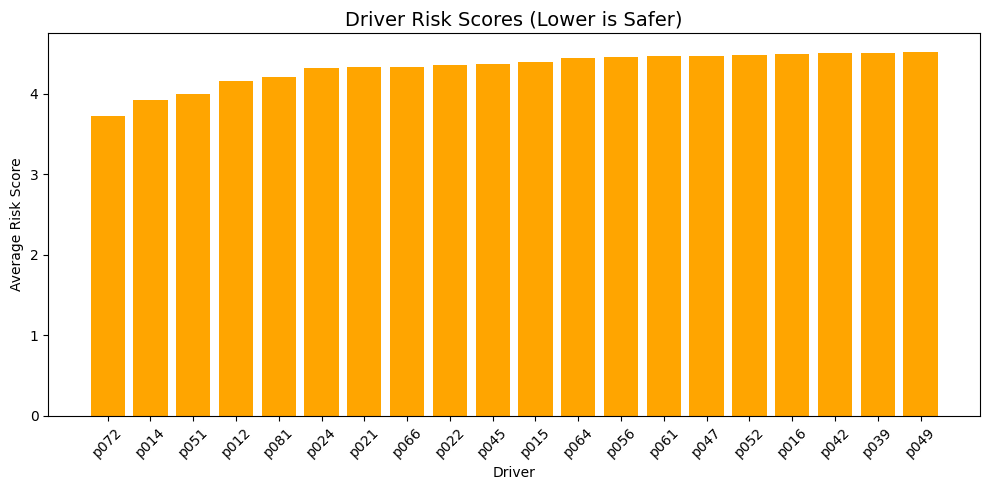

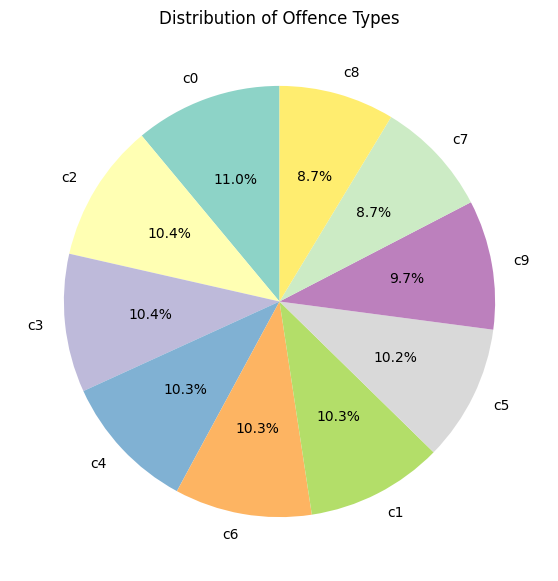

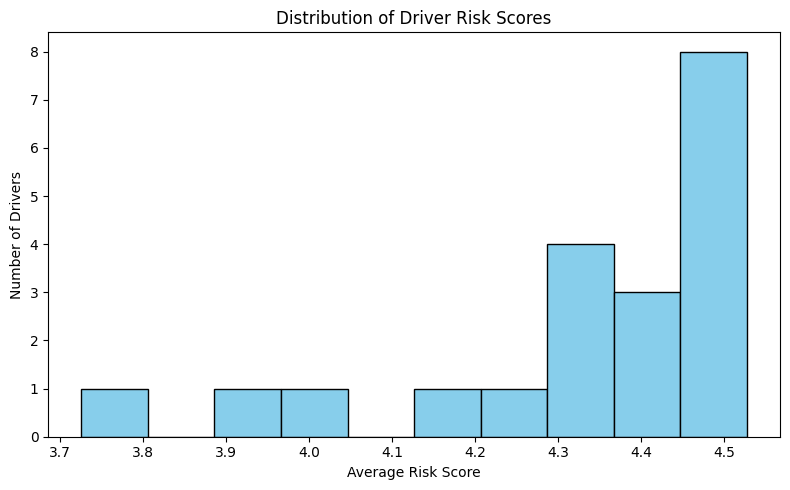

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


offence_weights = {
    'c0': 0,  
    'c1': 1,
    'c2': 2,
    'c3': 3,
    'c4': 4,
    'c5': 5,
    'c6': 6,
    'c7': 7,
    'c8': 8,
    'c9': 9
}


train_df['offence_score'] = train_df['classname'].map(offence_weights)


driver_scores = (
    train_df.groupby('subject')['offence_score']
    .mean()
    .reset_index()
    .rename(columns={'offence_score': 'risk_score'})
    .sort_values(by='risk_score', ascending=True)
)

print("\nDriver Risk Scores (lower is better):")
print(driver_scores)




plt.figure(figsize=(10, 5))
plt.bar(driver_scores['subject'], driver_scores['risk_score'], color='orange')
plt.title('Driver Risk Scores (Lower is Safer)', fontsize=14)
plt.xlabel('Driver')
plt.ylabel('Average Risk Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
train_df['classname'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.ylabel('')
plt.title('Distribution of Offence Types')
plt.show()


plt.figure(figsize=(8, 5))
plt.hist(driver_scores['risk_score'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Driver Risk Scores')
plt.xlabel('Average Risk Score')
plt.ylabel('Number of Drivers')
plt.tight_layout()
plt.show()


As an additional exploratory sidequest, a Driver Risk Scoring system was developed to quantify and visualize how risky or safe each driver appeared in the training dataset. Since the dataset contained subject IDs, it was possible to evaluate driver-level behavior rather than only focusing on image-level predictions.

To achieve this, each driving class (c0–c9) was assigned an offence severity weight, with safe driving (c0) given a score of 0 and progressively distracted behaviors (such as texting, talking on the phone, or operating electronic devices) given higher scores up to 9. This scoring framework reflected the relative severity of distraction types.

For each driver, an average risk score was computed by mapping their images to offence weights and taking the mean value. A lower risk score indicated safer overall behavior, while higher scores suggested drivers who were more frequently associated with distracted categories. This driver-level aggregation allowed identification of trends, such as whether certain drivers consistently exhibited higher-risk behavior patterns.

To better interpret these results, multiple visualizations were generated:

A bar chart comparing average driver risk scores, clearly highlighting safer versus riskier drivers.

A pie chart showing the distribution of offence types across the dataset, which helped in understanding class balance and the proportion of safe vs. distracted driving.

A histogram of risk scores across all drivers, giving a sense of the overall driver safety distribution in the dataset.

One important limitation was that this analysis could only be performed on the training set, since the test set did not include subject labels. Nevertheless, the exercise provided valuable insights into dataset biases and driver-specific patterns, ensuring that the model training was not disproportionately influenced by a few drivers with extreme behaviors.

In conclusion, the Driver Risk Scoring sidequest served as a useful interpretability and dataset fairness check, complementing the main classification pipeline and enhancing understanding of the underlying data.



graph1:  The table presents the average risk scores computed for each driver (identified by their subject ID). These scores were derived by mapping each driving instance to its offence severity weight (c0–c9) and calculating the mean score per driver. As a result, lower scores indicate safer overall driving behavior, while higher scores reflect more frequent engagement in risky, distracted activities.

For example, driver p072 achieved the lowest risk score (3.72), suggesting that this driver more often engaged in safe driving or low-risk behaviors. In contrast, driver p049 recorded the highest risk score (4.52), implying a greater tendency towards distracted driving categories. The spread of scores across drivers ranges from ~3.7 to ~4.5, indicating that while there are variations among drivers, most fall within a relatively close band of average risk levels.

This ranking provides valuable insight into inter-driver variability within the training dataset. Identifying safer and riskier drivers helps in assessing whether the dataset has biases (e.g., some drivers consistently riskier than others) and prevents the model from learning individual driver patterns rather than generalizable features of distracted driving.






graph2::    The bar chart illustrates the average risk scores per driver, ranked from lowest (safest) to highest (riskiest). Each bar represents a driver, with the y-axis showing their average offence-based risk score.

From the plot, we can clearly identify that:

Driver p072 has the lowest average risk score (~3.7), indicating the safest overall driving behavior among the group.

On the other hand, driver p049 has the highest average risk score (~4.5), suggesting a higher tendency towards risky or distracted driving actions.

Most drivers fall within a narrow score range (3.7–4.5), meaning that while there are safer and riskier individuals, the dataset does not contain extreme outliers in terms of driving safety.

This visualization makes the ranking more interpretable and highlights inter-driver variability within the dataset. Such insights are important to check whether the dataset is balanced, and whether the model might unintentionally learn driver-specific habits instead of general distracted driving patterns.


graph3 ::   The pie chart illustrates the distribution of offence types (c0 to c9) across the dataset. Each slice represents the proportion of images belonging to a particular distracted driving behaviour. From the chart, it is evident that the dataset is fairly balanced, with all offence types lying within a narrow range of ~8.7% to 11%.

The most frequent class is c0 (safe driving), contributing about 11% of the dataset.

The least frequent offence types are c7 (talking on the phone right) and c8 (talking on the phone left), each at around 8.7%.

All other classes (c1–c9) are distributed almost evenly between 9% and 10.4%.

This balanced distribution is advantageous for training machine learning models, as it reduces the risk of class imbalance bias where the model might otherwise favor more frequent offence types. As a result, the dataset provides a strong foundation for building a fair and generalizable distracted driving detection model.


graph4::  The histogram shows the distribution of driver risk scores calculated from the training dataset. Each driver was assigned an average risk score based on the frequency and severity of distracted behaviours observed. The x-axis represents the average risk score, while the y-axis shows the number of drivers falling into each range. From the chart, it can be observed that most drivers cluster around the higher end of the risk spectrum (4.3–4.5), indicating that many drivers consistently engaged in distracted driving behaviours. Only a few drivers had relatively lower risk scores (3.7–4.0), suggesting safer driving patterns. This distribution highlights that while some drivers exhibit safer driving tendencies, a significant portion of drivers are prone to distraction, which could be a valuable insight for targeted safety interventions.

2025-08-20 12:27:09.189265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755692829.574905      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755692829.687348      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1755692848.709319      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755692848.709965      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Found 79726 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1755693016.003429     107 service.cc:148] XLA service 0x7d1734002cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755693016.004966     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755693016.005033     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755693017.078459     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2492 ━━━━━━━━━━━━━━━━━━━━ 10:58:30 16s/step

I0000 00:00:1755693027.043044     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2492/2492 ━━━━━━━━━━━━━━━━━━━━ 990s 391ms/step


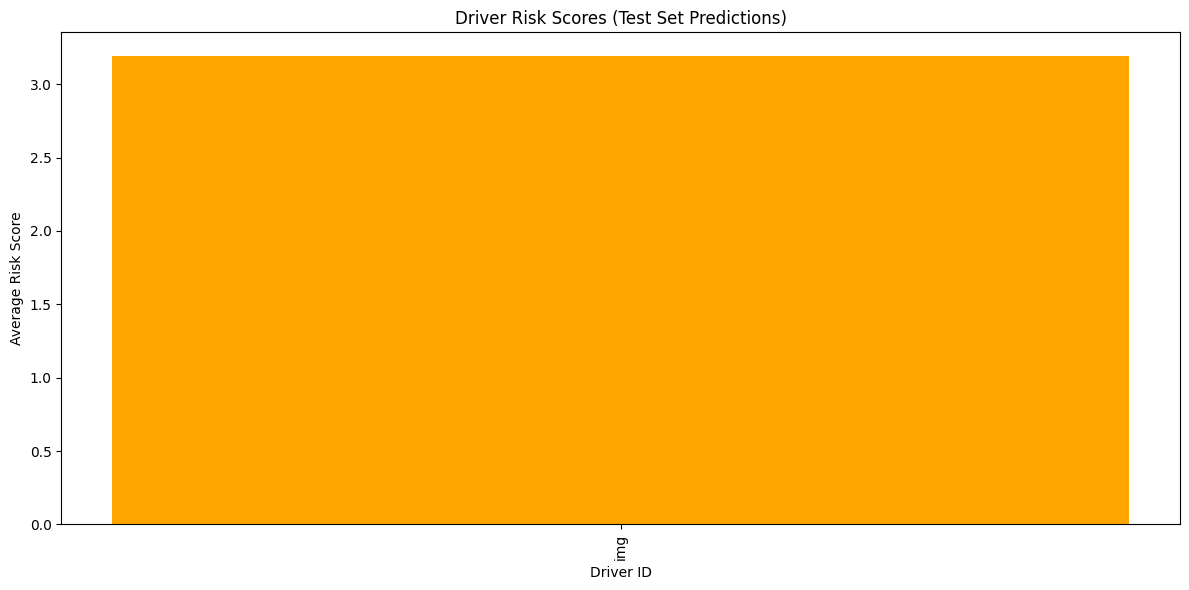

Safest Drivers (Lowest Risk):
  driver  risk_score
0    img    3.193356

Riskiest Drivers (Highest Risk):
  driver  risk_score
0    img    3.193356


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


model_path = "/kaggle/input/best_model/keras/default/1/best_model.h5"
model = load_model(model_path)


test_dir = "../input/state-farm-distracted-driver-detection/imgs/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory="../input/state-farm-distracted-driver-detection/imgs/",
    classes=['test'],
    target_size=(300, 300),  
    batch_size=32,
    class_mode=None,
    shuffle=False
)


preds = model.predict(test_generator, verbose=1)


classes = [f'c{i}' for i in range(10)]

filenames = [f.split('/')[-1] for f in test_generator.filenames]

pred_df = pd.DataFrame(preds, columns=classes)
pred_df['img'] = filenames


pred_df['driver'] = pred_df['img'].apply(lambda x: x.split('_')[0])


severity_weights = {
    'c0': 0,
    'c1': 5,
    'c2': 4,
    'c3': 5,
    'c4': 4,
    'c5': 3,
    'c6': 2,
    'c7': 3,
    'c8': 4,
    'c9': 2
}

pred_df['risk_score'] = pred_df.apply(
    lambda row: sum(row[c] * severity_weights[c] for c in classes),
    axis=1
)


driver_scores = pred_df.groupby('driver')['risk_score'].mean().reset_index()
driver_scores = driver_scores.sort_values(by='risk_score', ascending=True)


plt.figure(figsize=(12,6))
plt.bar(driver_scores['driver'], driver_scores['risk_score'], color='orange')
plt.xticks(rotation=90)
plt.xlabel("Driver ID")
plt.ylabel("Average Risk Score")
plt.title("Driver Risk Scores (Test Set Predictions)")
plt.tight_layout()
plt.show()


print("Safest Drivers (Lowest Risk):")
print(driver_scores.head())

print("\nRiskiest Drivers (Highest Risk):")
print(driver_scores.tail())


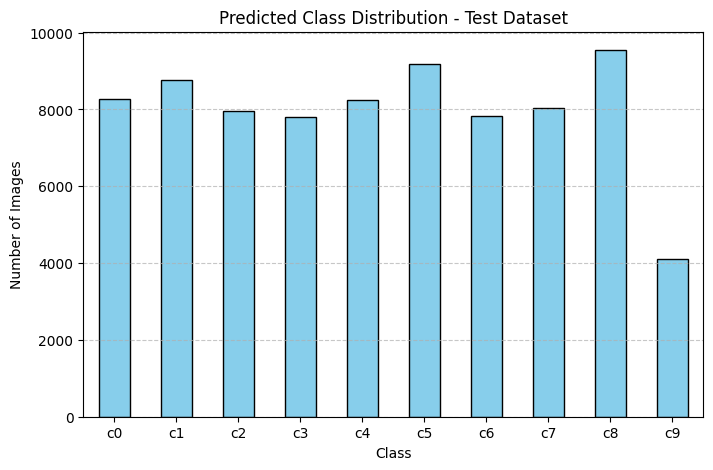

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


submission = pd.read_csv("/kaggle/input/hhhhhh/submission.csv")


class_cols = [f"c{i}" for i in range(10)]


submission["pred_class"] = submission[class_cols].idxmax(axis=1)


class_counts = submission["pred_class"].value_counts().sort_index()

plt.figure(figsize=(8,5))
class_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Predicted Class Distribution - Test Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


The predicted class distribution on the test dataset highlights how the trained model assigns samples across the ten classes. Overall, the distribution appears fairly balanced, with most classes (c0–c8) receiving between 7,500 and 9,500 predictions, demonstrating that the model does not exhibit severe bias toward any particular class.

However, one notable deviation is observed for class c9 (Talking to passenger), which has a significantly lower prediction count (around 4,000). This imbalance is consistent with the lower accuracy, precision, and recall previously reported for this class, suggesting that the model often misclassifies these instances as other distracted driving behaviors or as safe driving (c0).

On the other hand, class c8 (Hair and makeup) shows the highest prediction count (close to 9,600), indicating that the model is relatively more confident in identifying this activity.

This distribution analysis, when combined with the ROC curves, classification report, and confusion matrix, reinforces that while the model performs strongly overall, c9 remains the most challenging class, requiring additional focus in future improvements.

Classes: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


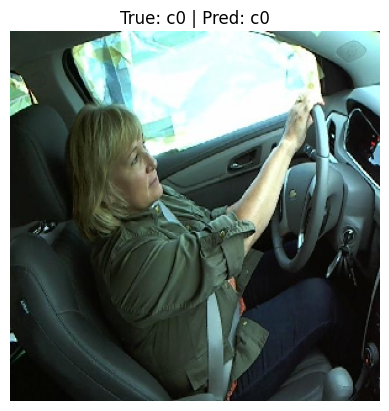

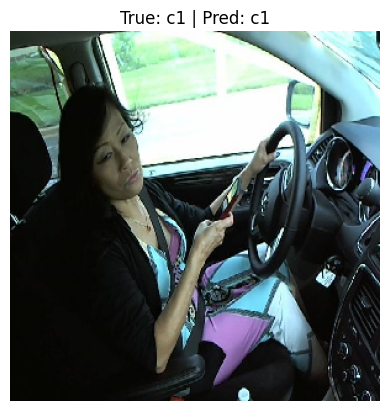

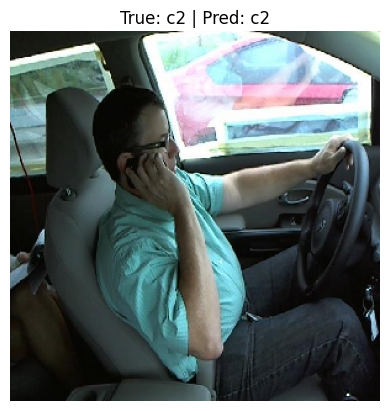

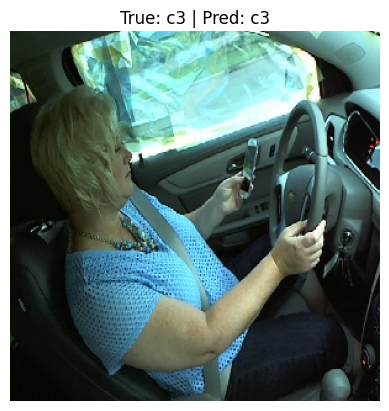

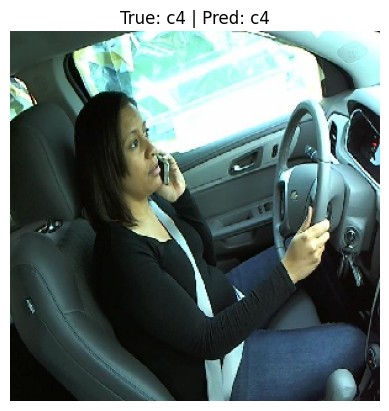

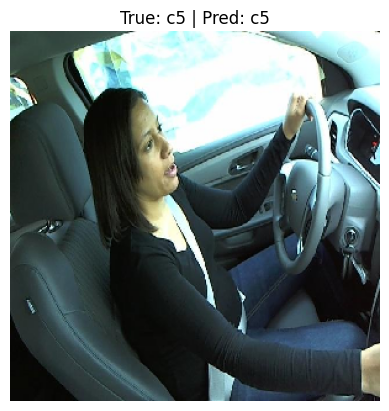

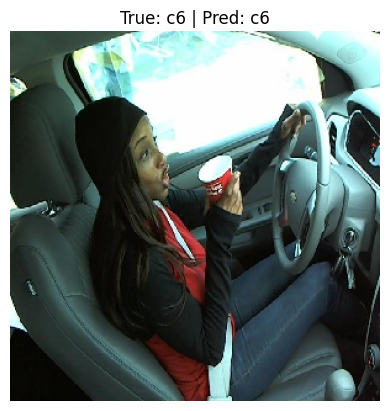

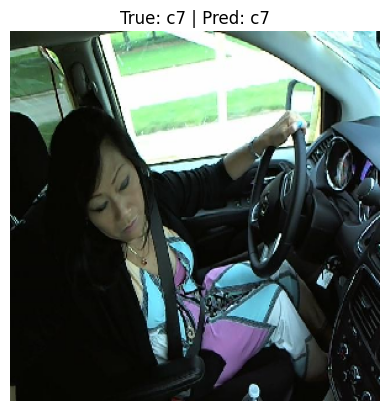

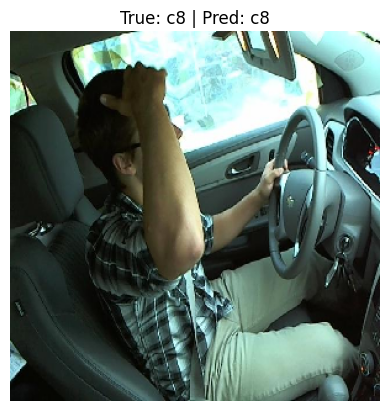

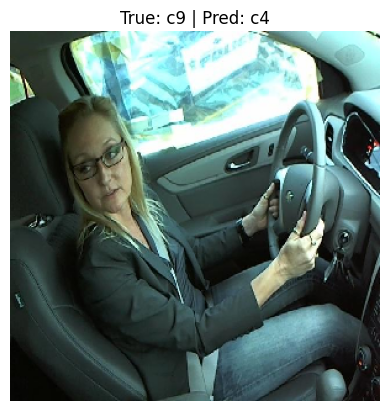

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input


model = load_model("/kaggle/input/best_model/keras/default/1/best_model.h5")


base_dir = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"


class_names = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
print("Classes:", class_names)


sample_images = []
for cls in class_names:
    cls_dir = os.path.join(base_dir, cls)
    imgs = os.listdir(cls_dir)
    chosen = random.sample(imgs, 1)  
    sample_images.extend([os.path.join(cls_dir, fname) for fname in chosen])

IMG_SIZE = (300, 300)


for img_path in sample_images:
    
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

   
    preds = model.predict(img_array, verbose=0)
    pred_class = class_names[np.argmax(preds[0])]
    true_class = os.path.basename(os.path.dirname(img_path))  

  
    plt.imshow(img)
    plt.title(f"True: {true_class} | Pred: {pred_class}")
    plt.axis("off")
    plt.show()
